# Data Exploration

Here, we will be performing an exhaustive analysis to gain insights Into the the training, test and store data.

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns
import plotly.io as pio
from IPython.display import Image

In [3]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
colors = ['#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF',
          '#FECB52', '#636EFA', '#EF553B', '#00CC96', '#AB63FA', ]

In [5]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_cleaner import DfCleaner
from df_outlier import DfOutlier
from file_handler import FileHandler
from vis_plotly import VisPlotly
from vis_seaborn import VisSeaborn
from df_overview import DfOverview

2021-08-02 00:14:52,006 — DfOverview — DEBUG — Loaded successfully!


In [6]:
sn = VisSeaborn()
file_handler = FileHandler()

## Data

In [7]:
df_store = file_handler.read_csv('../data/store.csv')
df_train = file_handler.read_csv('../data/train.csv')
df_test = file_handler.read_csv('../data/test.csv')

2021-08-02 00:15:20,925 — DfHelper — ERROR — file not found
Traceback (most recent call last):
  File "/Users/ea/Projects/PharmaceuticalSalesPrediction/scripts/file_handler.py", line 37, in read_csv
    df = pd.read_csv(csv_path, na_values=missing_values)
  File "/Users/ea/Library/Python/3.8/lib/python/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/Users/ea/Library/Python/3.8/lib/python/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/Users/ea/Library/Python/3.8/lib/python/site-packages/pandas/io/parsers/readers.py", line 482, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/Users/ea/Library/Python/3.8/lib/python/site-packages/pandas/io/parsers/readers.py", line 811, in __init__
    self._engine = self._make_engine(self.engine)
  File "/Users/ea/Library/Python/3.8/lib/python/site-packages/pandas/io/parsers/readers.py", line 1040, in _

In [7]:
stores_types = ["Store type A", "Store type B", "Store type C", "Store type D"]
state_holidays = [ "Normal Day", "Public holiday", "Easter holiday", "Christmas"] 
school_holidays = ["School is closed", "School is open"]
assortment = [ "Basic", "Extra", "Extended"] 
promo = ["Not participating", "Participating"]
store_open = ["Closed", "Open"]

## Comparing Test and Train data

In [8]:
train_data = df_train.copy()
test_data = df_test.copy()

A good place to start will be to check if the test data is representative of the training data.

In [9]:
def compare_test_train(train_data, test_data, feature, title):
  fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
  ax[0].set_title("Train " + title)
  sns.countplot(x=feature, data=train_data, ax=ax[0])
  ax[1].set_title("Test " + title)
  sns.countplot(x=feature, data=test_data, ax=ax[1])
  fig.subplots_adjust(wspace=0.3)
  fig.show()

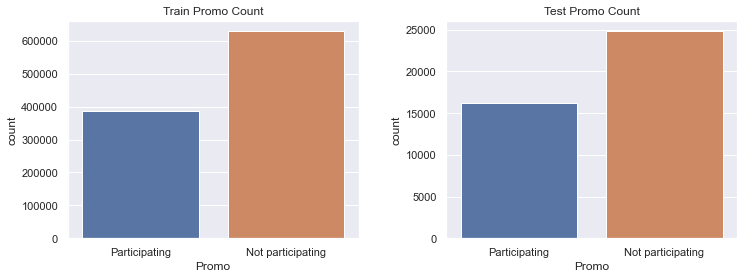

In [10]:
train_data["Promo"] = train_data["Promo"].apply(lambda x: promo[x])
test_data["Promo"] = test_data["Promo"].apply(lambda x: promo[x])
compare_test_train(train_data, test_data, 'Promo', "Promo Count")

As we can see stores participating in the promotion are in similar proportion in training and test data.

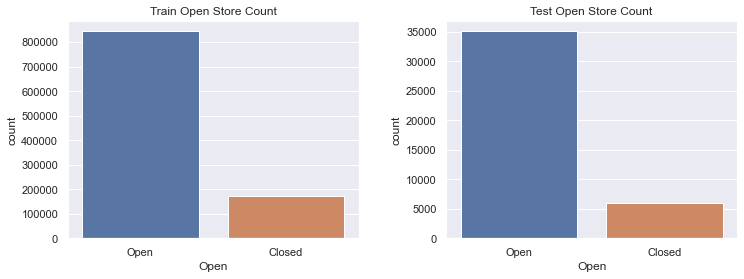

In [11]:
train_data["Open"] = train_data["Open"].apply(lambda x: store_open[x])
test_data["Open"] = test_data["Open"].apply(lambda x: store_open[x])
compare_test_train(train_data, test_data, 'Open', "Open Store Count")

Here also there is a similar proportion between training and test data in number of stores open and closed.

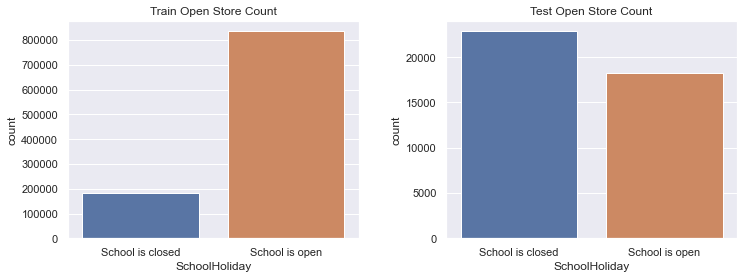

In [12]:
train_data["SchoolHoliday"] = train_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
test_data["SchoolHoliday"] = test_data["SchoolHoliday"].apply(lambda x: school_holidays[x])
compare_test_train(train_data, test_data, 'SchoolHoliday', "Open Store Count")

This will be the first problem to correctly predicting sales for test data. On our test data
Schools are more closed than open. This is not normal, the more representative data is the training data, in which there are far more days schools are open than closed.

In [13]:
state_holiday_train = train_data.groupby(['StateHoliday']).agg({'StateHoliday': ['count']})
state_holiday_train.columns = ['count']
state_holiday_train = state_holiday_train.reset_index()
state_holiday_train["StateHoliday"] = state_holiday_train["StateHoliday"].apply(lambda x: state_holidays[x])
state_holiday_train

,StateHoliday,count
0,Normal Day,986159
1,Public holiday,20260
2,Easter holiday,6690
3,Christmas,4100


In [14]:
state_holiday_test = df_test.groupby(['StateHoliday']).agg({'StateHoliday': ['count']})
state_holiday_test.columns = ['count']
state_holiday_test = state_holiday_test.reset_index()
state_holiday_test["StateHoliday"] = state_holiday_test["StateHoliday"].apply(lambda x: state_holidays[x])
state_holiday_test

,StateHoliday,count
0,Normal Day,40908
1,Public holiday,180


This is the other problem in the test data. For the training data, the proportion of normal days to public holidays is 0.02. This means for every 100 normal days we have 2 public holidays. But for the test data, it's 0.004, which is for 1000 normal days 4 public holidays. The other problem is Easter and Christmas are not in the test data.

## Joining store and train datasets

Now I will join Store and train data. Further analysis will be done using the joint columns.
I will also add `Day`, `Month`, and `Year` columns from the date column.

In [22]:
df_train_store = pd.merge(df_train.reset_index(), df_store, how='inner', on='Store')
df_train_store.shape

(1017209, 22)

In [23]:
df_train_store['Date'] = pd.DatetimeIndex(df_train_store['Date'])
df_train_store['Year'] = pd.DatetimeIndex(df_train_store['Date']).year
df_train_store['Month'] = pd.DatetimeIndex(df_train_store['Date']).month
df_train_store['Day'] = pd.DatetimeIndex(df_train_store['Date']).day
df_train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   index                      1017209 non-null  int64         
 1   Store                      1017209 non-null  int64         
 2   DayOfWeek                  1017209 non-null  int64         
 3   Date                       1017209 non-null  datetime64[ns]
 4   Sales                      1017209 non-null  int64         
 5   Customers                  1017209 non-null  int64         
 6   Open                       1017209 non-null  int64         
 7   Promo                      1017209 non-null  int64         
 8   StateHoliday               1017209 non-null  int64         
 9   SchoolHoliday              1017209 non-null  int64         
 10  StoreType                  1017209 non-null  int64         
 11  Assortment                 1017209 no

## Seasonality

Let's start by looking for seasonality in the data.

In [24]:
df = df_train_store.copy()

In [25]:
df["StoreType"] = df["StoreType"].apply(lambda x: stores_types[x])
store_type_df = df.groupby('StoreType').agg({'Customers': 'mean', 'Sales': 'mean'})
store_type_df = store_type_df.reset_index()
store_type_df


,StoreType,Customers,Sales
0,Store type A,640.03,5640.54
1,Store type B,1321.56,9198.32
2,Store type C,663.82,5668.12
3,Store type D,501.29,5611.88


Store type B has more than doubles the customer count than another store. It also has double average sales than the other stores.

In [26]:
date_df = df.groupby('Year').agg({'Customers': 'mean', 'Sales': 'mean'})
date_df = date_df.reset_index()
date_df.head()

,Year,Customers,Sales
0,2013,607.24,5574.86
1,2014,620.08,5747.61
2,2015,603.79,5800.55


The stores have similar average sales and average customer count throughout the three years

In [27]:
def plot_trend(df, columns, feature, title, x_label="", y_label="", labels=['']):
  plt.figure(figsize=(18, 6))
  for i in range(len(columns)):
    sns.lineplot(x=df.index, y=df[columns[i]][feature], label=labels[i])
  plt.title(title, fontsize=15, fontweight='bold')
  plt.ylabel(x_label, fontsize=14)
  plt.xlabel(y_label, fontsize=14)
  plt.show()

In [28]:
daily_trend = df.groupby(['Day', 'StoreType']).agg({'Customers': 'mean', 'Sales': 'mean'})
daily_trend = daily_trend.unstack().swaplevel(0, 1, 1).sort_index(1)

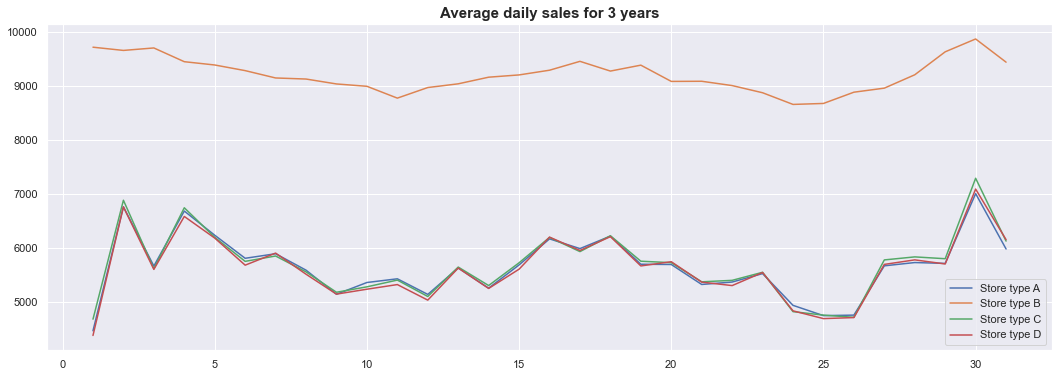

In [22]:
columns = ["Store type A", "Store type B", "Store type C", "Store type D"]
plot_trend(daily_trend, columns, 'Sales', 'Average daily sales for 3 years', labels=columns)

Here we can see there is a very similar trend in through a month between the stores. Store B has more sales but still, the shape of the graph is similar.

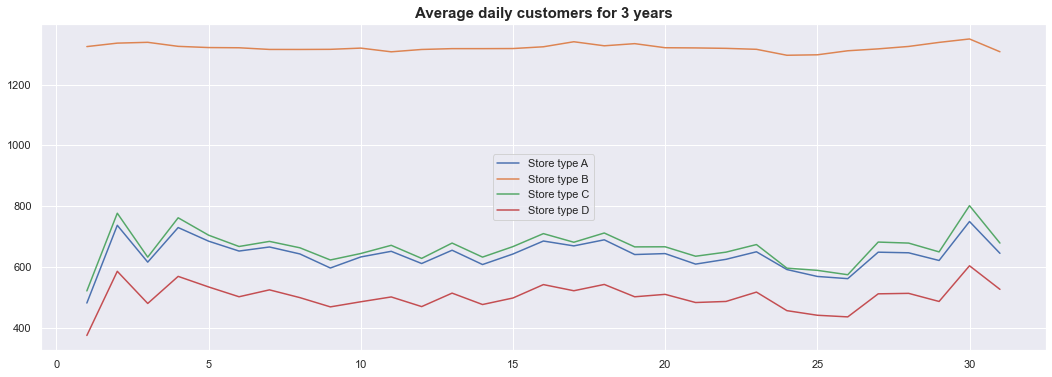

In [23]:
plot_trend(daily_trend, columns, 'Customers', 'Average daily customers for 3 years', labels=columns)

We can observe there is a similarity between the average sales and the average number of customers.

In [24]:
monthly_trend = df.groupby(['Month', 'StoreType']).agg( {'Customers': 'mean', 'Sales': 'mean'})
monthly_trend = monthly_trend.unstack().swaplevel(0, 1, 1).sort_index(1)

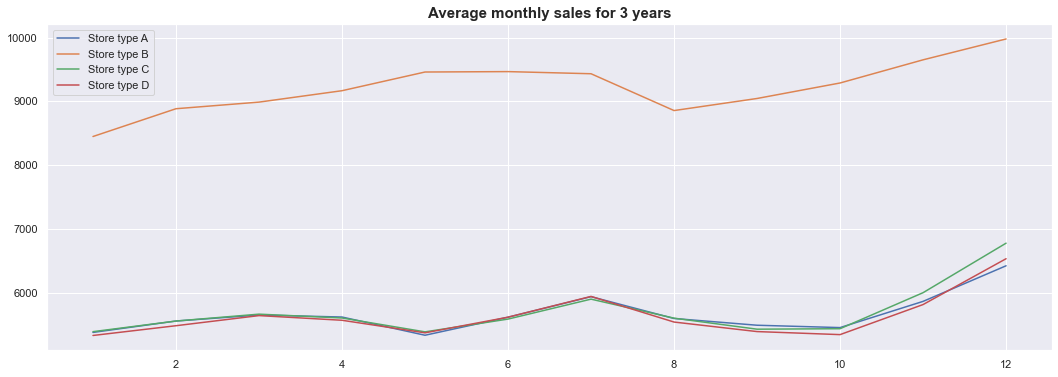

In [25]:
plot_trend(monthly_trend, columns, 'Sales', 'Average monthly sales for 3 years', labels=columns)

We can see the high points in sales are April, July, and December.
To understand the reasons behind this we should consider the fact that the Rosman store is located in Germany.
These are the main holidays in Germany.
- January: New Year’s Day(Neujahrstag)
- April: Good Friday(Karfreitag)
- April: Easter Monday(Ostermontag)
- May: Labor Day(Maifeiertag)
- May: Ascension Day(Christi Himmelfahrt, 40 days after Easter)
- May: Whit Monday(Pfingstmontag) – seventh Monday after Easter.
- October: Day of German Unity(Tag der Deutschen Einheit)
- October: Reformation Day(Reformationstag) – generally a regional holiday in

Let's check in our data to confirm

In [36]:
df["StateHoliday"] = df["StateHoliday"].apply(lambda x: state_holidays[x])
df["SchoolHoliday"] = df["SchoolHoliday"].apply(lambda x: school_holidays[x])

In [44]:
public_holiday = df[["Month"]].loc[df["StateHoliday"] == state_holidays[1]]
easter_holiday = df[["Month"]].loc[df["StateHoliday"] == state_holidays[2]]
christmas_holiday = df[["Month"]].loc[df["StateHoliday"] == state_holidays[3]]

In [46]:
print("Public Hollydays are in months: ", np.sort(public_holiday["Month"].unique()))
print("Easter is in months: ", np.sort(easter_holiday["Month"].unique()))
print("Chrismass is in month: ", np.sort(christmas_holiday["Month"].unique()))

Public Hollydays are in months:  [ 1  5  6  8 10 11]
Easter is in months:  [3 4]
Chrismass is in month:  [12]


This confirms our assumption that the increase in sales is due to holiday shopping. There another Interesting point is, salles increase throughout the stores leading to this holidays and there is a decline in sells after this holidays.

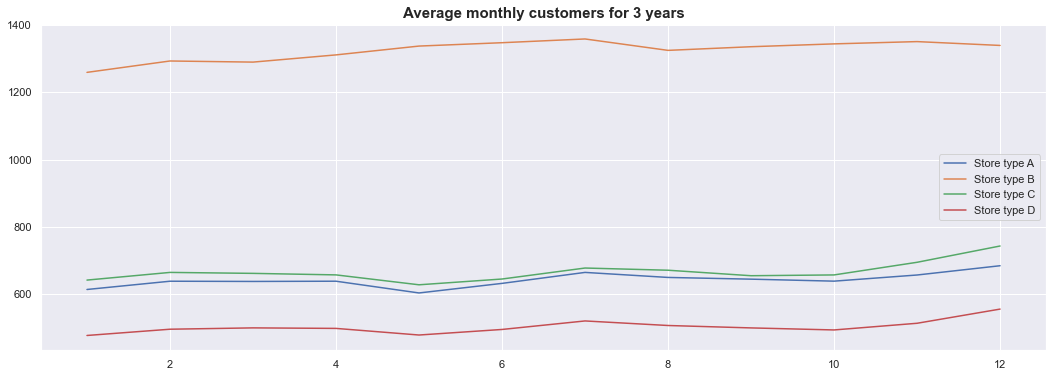

In [ ]:
plot_trend(monthly_trend, columns, 'Customers', 'Average monthly customers for 3 years', labels=columns)

here also we see similarities between sales and the number of customers. 
Next, we will explore this more in-depth.

## Correlation Analysis

In [33]:
df = df_train_store.copy()
corr_all = df_train_store[['Open', 'Promo', 'Promo2', 'Sales', 'Customers', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                           'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].corr()

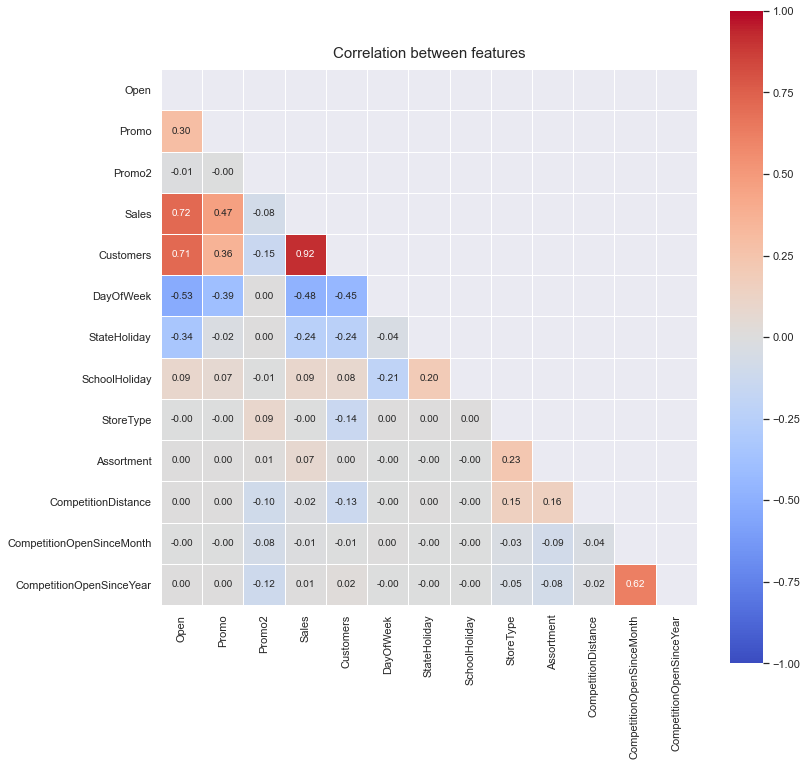

In [14]:
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 12))
heatmap = sns.heatmap(corr_all, mask=mask, square=True, linewidths=.5,
                      vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f')
heatmap.set_title('Correlation between features', fontdict={'fontsize': 15}, pad=12)
fig.show()


From the above correlation matrix, we observe the following. There is a strong positive correlation between sales and Customers. Promo has a positive correlation with sales and customers. State holidays and Days of the week have a negative correlation with sales and customers. We will explore these correlations more in-depth.

Impact of number of customers on sales. 

In [34]:
df["StoreType"] = df["StoreType"].apply(lambda x: stores_types[x])
df = df.sort_values(by='Day', ascending=False)


In [36]:
df = df.sort_values(by='Month', ascending=False)


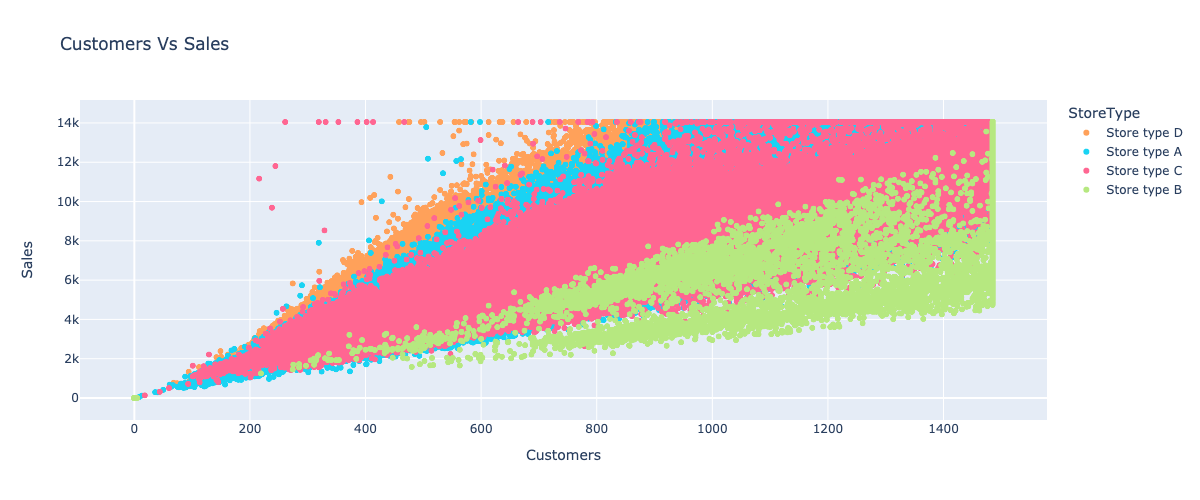

In [40]:
fig = px.scatter(df, x="Customers", y="Sales", color="StoreType",
                 color_discrete_sequence=colors, title="Customers Vs Sales")
Image(pio.to_image(fig, format='png', width=1200))
# fig.show()

As we can see when the number of customers increases sales also increase.

Impact of Promo on customers and sales

In [75]:
df["Promo"] = df["Promo"].apply(lambda x: promo[x])
df["Promo2"] = df["Promo2"].apply(lambda x: promo[x])

In [77]:
overall_trend = df.groupby(['Promo', 'Promo2',]).agg({'Customers': 'mean', 'Sales': 'mean'})
overall_trend

Customers   Sales
Promo             Promo2                              
Not participating Not participating     549.90 4653.15
                  Participating         451.17 4083.00
Participating     Not participating     858.88 8163.34
                  Participating         722.38 7508.55

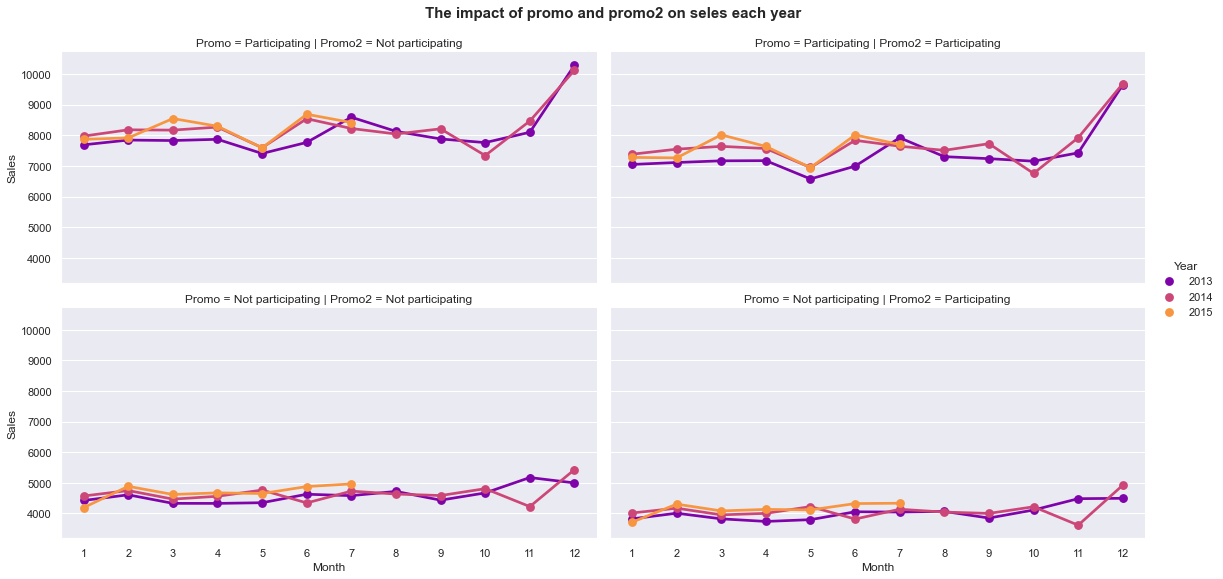

In [91]:
fp = sns.factorplot(data=df, x='Month', y="Sales", palette='plasma', hue='Year',
                    row='Promo', col='Promo2', color='green', size=4, aspect=2)
fp.fig.subplots_adjust(top=.9) 
fp.fig.suptitle("The impact of promo and promo2 on seles each year", fontsize=15, fontweight='bold')
plt.show()

This is the most interesting plot, I think. Promo 1 has a positive impact on sales and there is clearly more sales when the promo is running. Promo2 has a little bit of a negative impact on sales. From this, we can suggest the company should stop spending on Promo2 and 
they should focus more on Promo.

In [ ]:
sns.factorplot(data=df,
               x='Month',
               y="Customers",
               palette='plasma',
               hue='Year',
               row='Promo',
               col='Promo2',
               color='green')

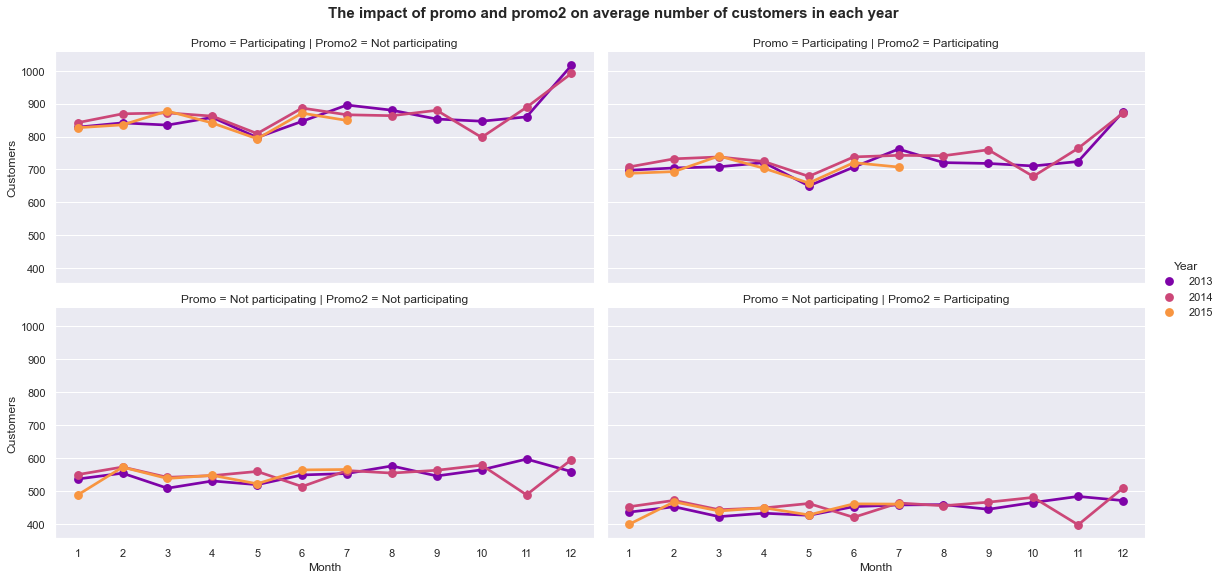

In [93]:
fp = sns.factorplot(data=df, x='Month', y="Customers", palette='plasma', hue='Year',
                    row='Promo', col='Promo2', color='green', size=4, aspect=2)
fp.fig.subplots_adjust(top=.9) 
fp.fig.suptitle("The impact of promo and promo2 on average number of customers in each year", fontsize=15, fontweight='bold')
plt.show()

This is similar with sales.

 customer behavior during store open and closing times

In [96]:
open_days_data = df[df['Open'] == 1]
closed_days_data = df[df['Open'] == 0]

In [101]:
open_days_data.groupby('Date')["Customers"].mean()

Date
2013-01-01   985.47
2013-01-02   729.06
2013-01-03   670.54
2013-01-04   691.15
2013-01-05   606.03
              ...  
2015-07-27   845.29
2015-07-28   765.95
2015-07-29   725.18
2015-07-30   751.36
2015-07-31   840.96
Name: Customers, Length: 942, dtype: float64

Impact of weekdays on sales

In [35]:
weekly_data = df.groupby(['DayOfWeek']).agg({'DayOfWeek': 'count', 'Customers': 'mean', 'Sales': 'mean'})
weekly_data.columns = ['count', 'Customers',	'Sales']
weekly_data

,count,Customers,Sales
DayOfWeek,,,
1,144730,781.51,7599.14
2,145664,736.73,6907.14
3,145665,700.53,6490.33
4,145845,675.86,6185.29
5,145845,718.93,6651.85
6,144730,636.84,5794.27
7,144730,24.98,183.36


In [37]:
weekdays_data = df[df['DayOfWeek'] < 6]
weekend_data = df[df['DayOfWeek'] >= 6]

Assortment type

In [ ]:
df["Assortment"] = df["Assortment"].apply(lambda x: assortment[x])

NameError: name 'title' is not defined

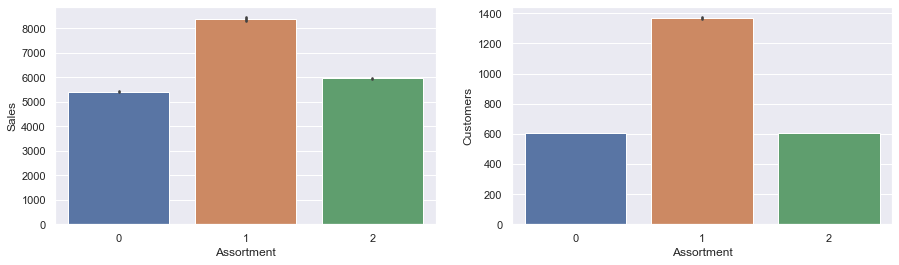

In [47]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x='Assortment', y='Sales', data=df, ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=df, ax=axis2)
axis1.set_title("Assortment Vs Sales " )
axis2.set_title("Assortment Vs Customers ")

impact of distance of competitor on sales


In [61]:
df_competition = df.groupby("Store").agg({ "Sales": "sum", 
                                           "Customers": "sum",
                                           "CompetitionDistance": "mean",
                                           "CompetitionOpenSinceYear": "mean",
                                           })
df_competition

,Sales,Customers,CompetitionDistance,CompetitionOpenSinceYear
Store,,,,
1,3716854,440523,1270.00,2008.00
2,3883858,457855,570.00,2007.00
3,5405105,584216,14130.00,2006.00
4,7523256,1014958,620.00,2009.00
5,3642818,418588,16107.00,2015.00
...,...,...,...,...
1111,4091076,351883,1900.00,2014.00
1112,7694122,652807,1880.00,2006.00
1113,5194013,561801,9260.00,1990.00


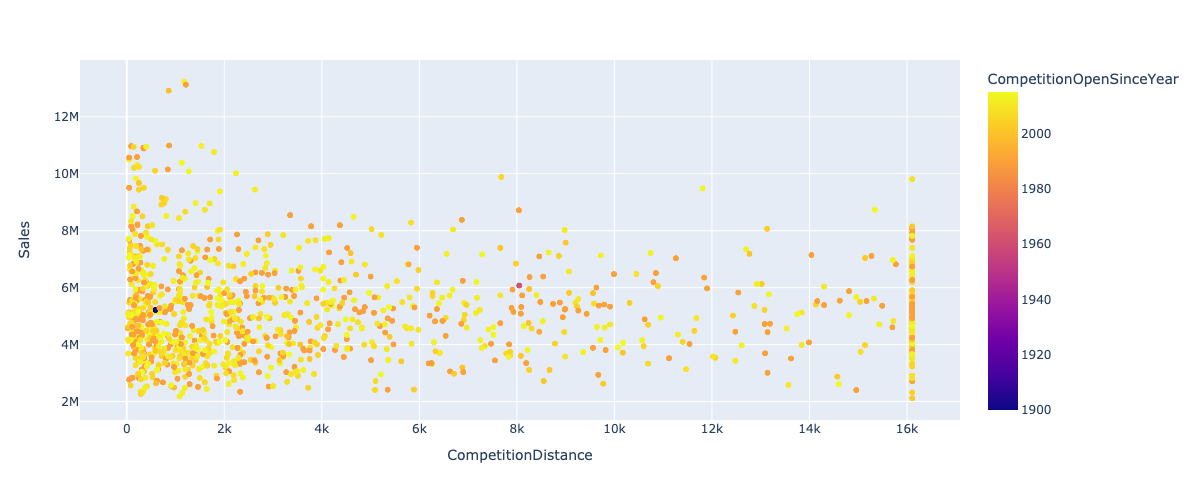

In [62]:
fig = px.scatter(df_competition, 
                 x="CompetitionDistance", 
                 y="Sales", 
                color="CompetitionOpenSinceYear")
Image(pio.to_image(fig, format='png', width=1200))

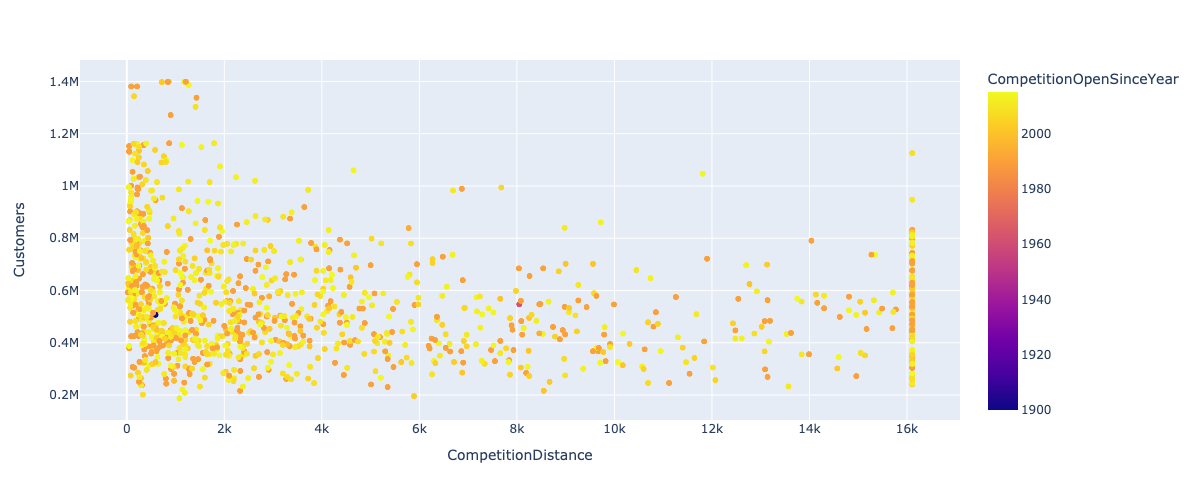

In [63]:
fig = px.scatter(df_competition, x="CompetitionDistance", y="Customers", color="CompetitionOpenSinceYear",
                 color_discrete_sequence=colors)
Image(pio.to_image(fig, format='png', width=1200))
